In [1]:
# Setup: load and prepare data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Load CSV
df = pd.read_csv('smmh.csv')

# Key columns
col_gender = '2. Gender'
col_rel = '3. Relationship Status'
col_occ = '4. Occupation Status'
col_platforms = '7. What social media platforms do you commonly use?'
col_usage = '8. What is the average time you spend on social media every day?'

# Clean gender into Male/Female/Other
g = df[col_gender].astype(str).str.strip().str.lower()
df['Gender_Clean'] = np.where(g.str.contains('female'), 'Female', np.where(g.str.contains('male'), 'Male', 'Other'))

# Usage order and minutes midpoint
usage_order = [
    'Less than an Hour',
    'Between 1 and 2 hours',
    'Between 2 and 3 hours',
    'Between 3 and 4 hours',
    'Between 4 and 5 hours',
    'More than 5 hours'
]
usage_mid = {
    'Less than an Hour': 30,
    'Between 1 and 2 hours': 90,
    'Between 2 and 3 hours': 150,
    'Between 3 and 4 hours': 210,
    'Between 4 and 5 hours': 270,
    'More than 5 hours': 330
}

df[col_usage] = df[col_usage].astype(str).str.strip()
df['Usage_Category'] = pd.Categorical(df[col_usage], categories=usage_order, ordered=True)
df['Usage_Minutes'] = df[col_usage].map(usage_mid)

# Platforms split and one-hot
platforms_series = df[col_platforms].fillna('').astype(str)
platforms_list = platforms_series.apply(lambda s: [p.strip() for p in s.split(',') if p.strip()])
all_platforms = sorted({p for sub in platforms_list for p in sub})
for p in all_platforms:
    df[f'PLAT_{p}'] = platforms_list.apply(lambda lst: 1 if p in lst else 0)

plat_cols = [c for c in df.columns if c.startswith('PLAT_')]
df['Platform_Count'] = df[plat_cols].sum(axis=1).replace(0, np.nan)

print('Prepared columns: Gender_Clean, Usage_Category, Usage_Minutes, platform dummies ->', len(plat_cols))


Prepared columns: Gender_Clean, Usage_Category, Usage_Minutes, platform dummies -> 9


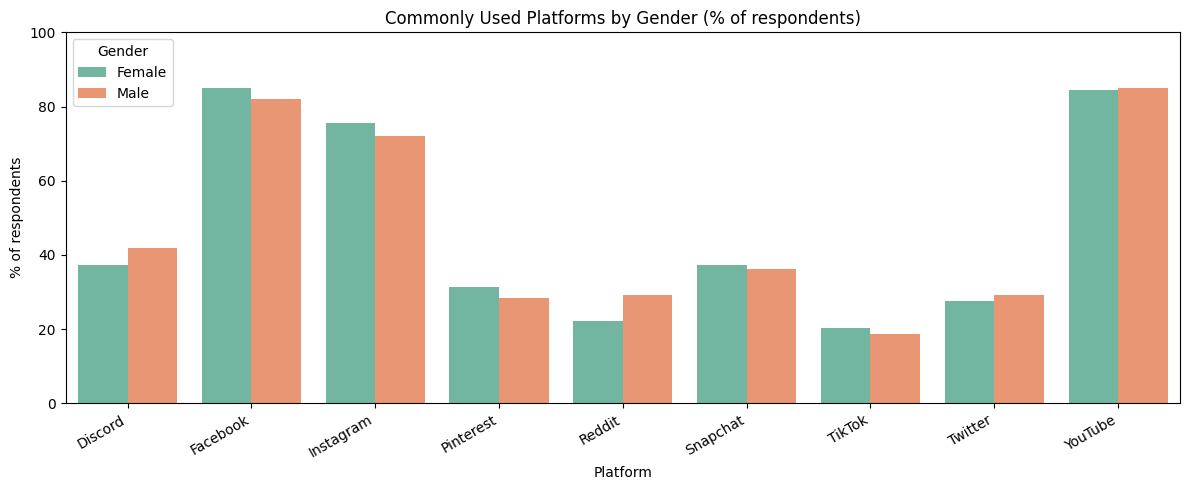

In [2]:
# 1) Commonly used platforms by respondents (Male vs Female) - Percent bars
# Compute percent of respondents selecting each platform within gender
mf_df = df[df['Gender_Clean'].isin(['Male','Female'])].copy()
plat_cols = [c for c in df.columns if c.startswith('PLAT_') and not c.endswith('_pct')]

summary = []
for pcol in plat_cols:
    platform = pcol[len('PLAT_'):]
    for gender, gdata in mf_df.groupby('Gender_Clean'):
        num = gdata[pcol].sum()
        denom = len(gdata)
        pct = 100 * num / denom if denom else np.nan
        summary.append({'Platform': platform, 'Gender': gender, 'Percent': pct})
platform_pct = pd.DataFrame(summary)

plt.figure(figsize=(12,5))
sns.barplot(data=platform_pct, x='Platform', y='Percent', hue='Gender', palette='Set2')
plt.xticks(rotation=30, ha='right')
plt.title('Commonly Used Platforms by Gender (% of respondents)')
plt.ylabel('% of respondents')
plt.xlabel('Platform')
plt.ylim(0, 100)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


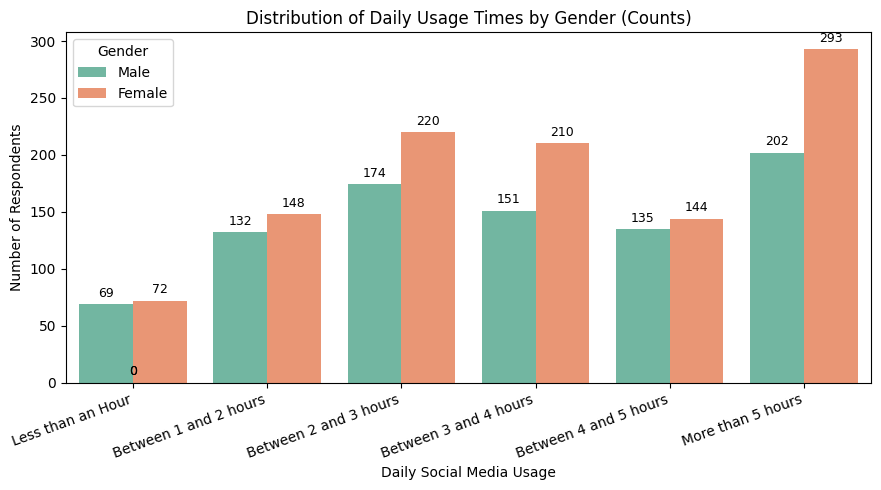

In [3]:
# 2) Distribution of Daily Social Media Usage Times with Number of Respondents by Gender
plt.figure(figsize=(9,5))
order = [
    'Less than an Hour',
    'Between 1 and 2 hours',
    'Between 2 and 3 hours',
    'Between 3 and 4 hours',
    'Between 4 and 5 hours',
    'More than 5 hours'
]
ax = sns.countplot(data=df[df['Gender_Clean'].isin(['Male', 'Female'])], x='Usage_Category', hue='Gender_Clean', order=order, palette='Set2')
plt.xticks(rotation=20, ha='right')
plt.xlabel('Daily Social Media Usage')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Daily Usage Times by Gender (Counts)')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()


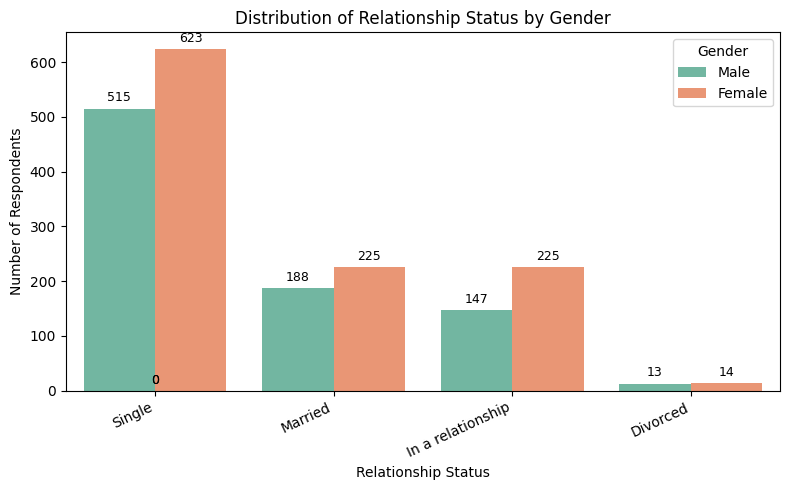

Relationship status counts for Male and Female:
3. Relationship Status
Single               1138
Married               413
In a relationship     372
Divorced               27
Name: count, dtype: int64

Relationship status percentages for Male and Female:
3. Relationship Status
Single               58.4
Married              21.2
In a relationship    19.1
Divorced              1.4
Name: count, dtype: float64


ValueError: cannot insert Gender_Clean, already exists

In [4]:
# 3) Relationship distribution and quick insights for Male and Female
plt.figure(figsize=(8,5))
ax = sns.countplot(data=df[df['Gender_Clean'].isin(['Male', 'Female'])], x=col_rel, hue='Gender_Clean', order=df[col_rel].value_counts().index, palette='Set2')
plt.xticks(rotation=25, ha='right')
plt.xlabel('Relationship Status')
plt.ylabel('Number of Respondents')
plt.title('Distribution of Relationship Status by Gender')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width()/2., height),
                ha='center', va='bottom', fontsize=9, xytext=(0,3), textcoords='offset points')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Insights for Male and Female
counts = df[df['Gender_Clean'].isin(['Male', 'Female'])][col_rel].value_counts(dropna=False)
perc = (counts / len(df[df['Gender_Clean'].isin(['Male', 'Female'])]) * 100).round(1)
print('Relationship status counts for Male and Female:')
print(counts)
print('\nRelationship status percentages for Male and Female:')
print(perc)

# Relationship by gender (stacked %)
rel_gender = (
    df[df['Gender_Clean'].isin(['Male','Female'])]
      .groupby(['Gender_Clean', col_rel])
      .size()
      .groupby(level=0)
      .apply(lambda s: s / s.sum() * 100)
      .reset_index(name='Percent')
)
plt.figure(figsize=(9,5))
sns.barplot(data=rel_gender, x=col_rel, y='Percent', hue='Gender_Clean', palette='Pastel2')
plt.xticks(rotation=25, ha='right')
plt.ylabel('Percent within gender')
plt.title('Relationship Status by Gender (%)')
plt.tight_layout()
plt.show()


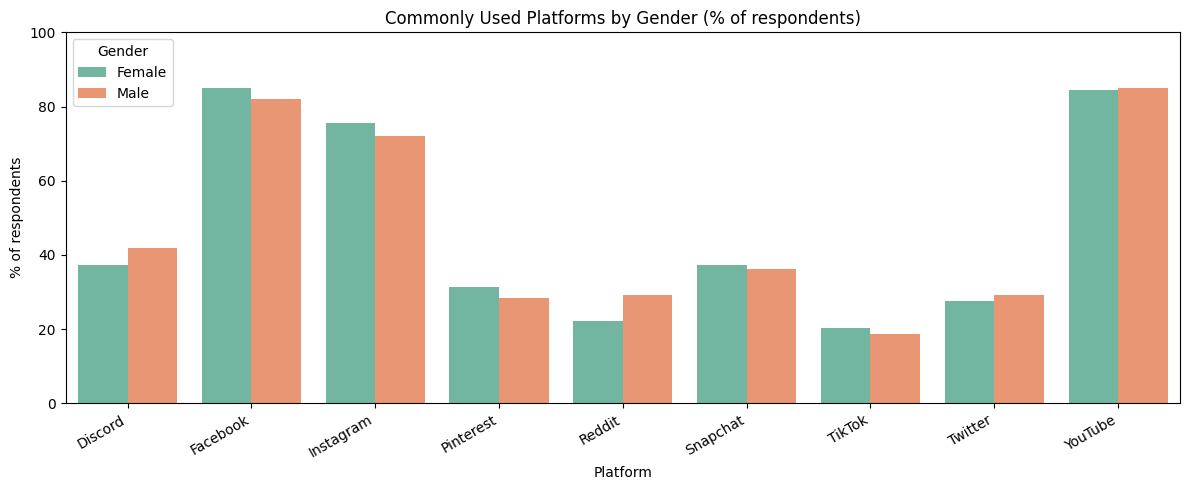

Status: The plot displays the percentage of male and female respondents who commonly use each platform. The data is grouped by gender and shows the distribution of platform usage as a percentage of total respondents within each gender.


In [6]:
# 1) Commonly used platforms by respondents (Male vs Female) - Percent bars
# Compute percent of respondents selecting each platform within gender

# Check if 'Gender_Clean' column exists in the DataFrame
if 'Gender_Clean' not in df.columns:
    # Attempt to create 'Gender_Clean' column if it doesn't exist
    if 'Gender' in df.columns:
        df['Gender_Clean'] = df['Gender'].str.strip().str.capitalize()
    else:
        print("Error: Neither 'Gender_Clean' nor 'Gender' column found in the DataFrame.")
else:
    mf_df = df[df['Gender_Clean'].isin(['Male','Female'])].copy()
    plat_cols = [c for c in df.columns if c.startswith('PLAT_') and not c.endswith('_pct')]

    summary = []
    for pcol in plat_cols:
        platform = pcol[len('PLAT_'):]
        for gender, gdata in mf_df.groupby('Gender_Clean'):
            num = gdata[pcol].sum()
            denom = len(gdata)
            pct = 100 * num / denom if denom else np.nan
            summary.append({'Platform': platform, 'Gender': gender, 'Percent': pct})
    platform_pct = pd.DataFrame(summary)

    plt.figure(figsize=(12,5))
    sns.barplot(data=platform_pct, x='Platform', y='Percent', hue='Gender', palette='Set2')
    plt.xticks(rotation=30, ha='right')
    plt.title('Commonly Used Platforms by Gender (% of respondents)')
    plt.ylabel('% of respondents')
    plt.xlabel('Platform')
    plt.ylim(0, 100)
    plt.legend(title='Gender')
    plt.tight_layout()
    plt.show()

    # Status Description
    print("Status: The plot displays the percentage of male and female respondents who commonly use each platform. "
          "The data is grouped by gender and shows the distribution of platform usage as a percentage of total respondents within each gender.")



Distribution of Mental Status categories:
Mental_Status
Unknown    1981
Name: count, dtype: int64


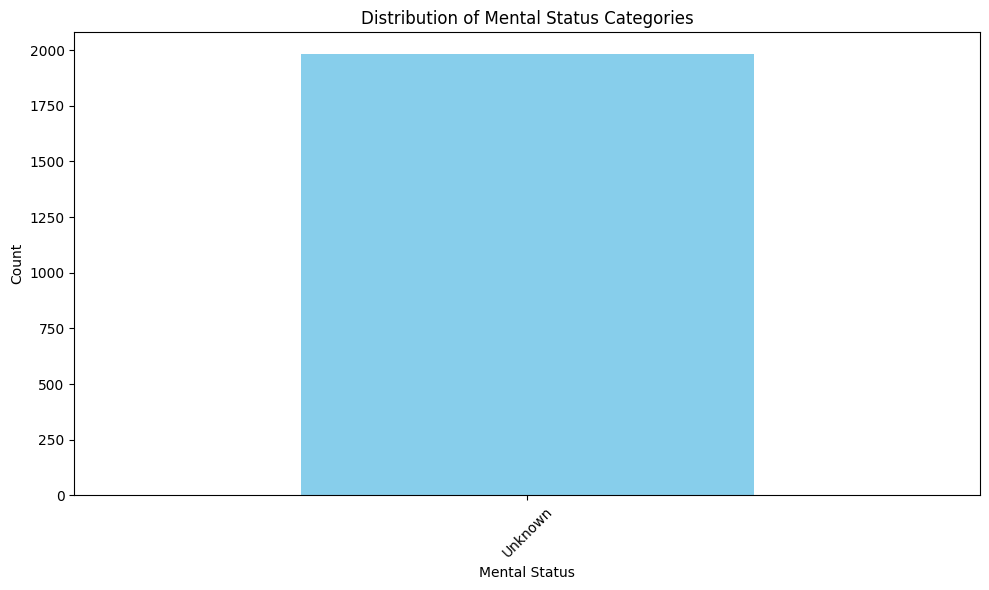


Correlation between Mental_Status and key features:


In [7]:
# Feature Engineering: Create Mental Status column based on relevant features

# Define the features that contribute to mental status assessment
mental_health_features = [
    'Bothered_By_Worries', 
    'Difficulty_Concentrating', 
    'Depressed_Or_Down', 
    'Interest_Fluctuation', 
    'Sleep_Issues',
    'SM_Usage_Without_Purpose',
    'SM_Distraction',
    'Restless_Without_SM',
    'Easily_Distracted',
    'Social_Media_Comparison',
    'Negative_Comparison_Feelings',
    'Validation_Seeking'
]

# Create a function to calculate mental status score
def calculate_mental_status(row):
    # Extract relevant features that exist in the dataframe
    valid_features = [f for f in mental_health_features if f in row.index]
    
    if not valid_features:
        return "Unknown"  # No relevant features found
    
    # Calculate the average score from available features
    total_score = sum(row[feature] for feature in valid_features)
    avg_score = total_score / len(valid_features)
    
    # Classify based on average score
    if avg_score <= 1.5:
        return "Mild"
    elif avg_score <= 2.5:
        return "Minimal Moderate"
    elif avg_score <= 3.5:
        return "Moderate"
    elif avg_score <= 4.5:
        return "Severe"
    else:
        return "Extremely Severe"

# Apply the function to create the new column
df['Mental_Status'] = df.apply(calculate_mental_status, axis=1)

# Display the distribution of mental status categories
mental_status_counts = df['Mental_Status'].value_counts()
print("\nDistribution of Mental Status categories:")
print(mental_status_counts)

# Visualize the distribution
plt.figure(figsize=(10, 6))
mental_status_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Mental Status Categories')
plt.xlabel('Mental Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check correlation between Mental_Status and other key features
print("\nCorrelation between Mental_Status and key features:")
# Convert Mental_Status to numeric for correlation analysis
status_mapping = {
    'Mild': 1, 
    'Minimal Moderate': 2, 
    'Moderate': 3, 
    'Severe': 4, 
    'Extremely Severe': 5
}
df['Mental_Status_Numeric'] = df['Mental_Status'].map(status_mapping)

# Calculate correlations with key features
for feature in [f for f in mental_health_features if f in df.columns]:
    correlation = df['Mental_Status_Numeric'].corr(df[feature])
    print(f"- {feature}: {correlation:.4f}")
